In this notebook, I describe in more details some functions in SAM and their use cases.

In the `SAM.py` module:
- `load_data`
- `load_obs_annotations`
- `load_var_annotations`
- `preprocess_data`
- `run`
- `clustering`
- `identify_marker_genes_rf`

In the `utilities.py` module:
- `find_corr_genes`

In [12]:
from SAM import SAM
import utilities as ut
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
sam=SAM()

## load_data
This function can load data into SAM from a variety of file formats.

In [2]:
sam.load_data('../../example_data/schisto2.5_tpm.csv.gz', #filename
      transpose=True, #Transpose the data. Set to True if the file is genes x cells. Ignored if file is not '.csv' or '.txt'.
      save_sparse_file=None, #Path (e.g. 'folder/data.h5ad'). Saves sparse representation of the data to an '.h5ad' file.
      sep=',') #Delimeter (i.e. ',' or '\t' or ' '). Ignored if file is not '.csv' or '.txt'.
      #**kwargs - extra arguments can be passed into pandas.read_csv or anndata.read_h5ad.

## load_obs_annotations
This loads cell annotations from a file or a preloaded pandas.DataFrame into `sam.adata_raw.obs` and `sam.adata.obs`. The keys added correspond to the column labels in the input table.

In [3]:
"""Loads cell annotations.

Loads the cell annotations into .adata_raw.obs and .adata.obs.

Parameters
----------
aname - string or pandas.DataFrame
    If string, it is the path to the annotations file, which should be
    a table with the first column being the cell IDs and the first row
    being the column names for the annotations. Alternatively, you can
    directly pass in a preloaded pandas.DataFrame.

sep - string, default ','
    The delimeter used in the file. Ignored if passing in a preloaded
    pandas.DataFrame.

""";

## load_var_annotations
This loads gene annotations from a file or a preloaded pandas.DataFrame into `sam.adata_raw.var` and `sam.adata.var`. The keys added correspond to the column labels in the input table.

In [4]:
"""Loads gene annotations.

Loads the gene annotations into .adata_raw.var and .adata.var. The keys
added correspond to the column labels in the input table.

Parameters
----------
aname - string or pandas.DataFrame
    If string, it is the path to the annotations file, which should be
    a table with the first column being the gene IDs and the first row
    being the column names for the annotations. Alternatively, you can
    directly pass in a preloaded pandas.DataFrame.

sep - string, default ','
    The delimeter used in the file. Ignored if passing in a preloaded
    pandas.DataFrame.

""";

## preprocess_data

This function preprocesses the data (i.e. normalizing library size, log-normalizing expression values, filtering out low-expressing genes, etc).

Genes that are filtered out will have all their gene-expressions set to zero in `sam.adata`. The docstring below details the available parameters and their default values.

In [5]:
"""
Parameters
----------

div : float, optional, default 1
    The factor by which the gene expression will be divided prior to
    normalization (e.g. log normalization).

downsample : float, optional, default 0
    The factor by which to randomly downsample the data. If 0, the
    data will not be downsampled.

sum_norm : str or float, optional, default None
    If a float, the total number of transcripts in each cell will be
    normalized to this value prior to normalization and filtering.
    Otherwise, nothing happens. If 'cell_median', each cell is
    normalized to have the median total read count per cell. If
    'gene_median', each gene is normalized to have the median total
    read count per gene.

norm : str, optional, default 'log'
    If 'log', log-normalizes the expression data. If 'ftt', applies the
    Freeman-Tukey variance-stabilization transformation. If
    'multinomial', applies the Pearson-residual transformation (this is
    experimental and should only be used for raw, un-normalized UMI
    datasets). If None, the data is not normalized.

include_genes : array-like of string, optional, default None
    A vector of gene names that specifies the genes to keep.
    All other genes will be filtered out. Gene names are case-
    sensitive.

exclude_genes : array-like of string, optional, default None
    A vector of gene names that specifies the genes to
    exclude. These genes will be filtered out. Gene names are case-
    sensitive.

include_cells : array-like of string, optional, default None
    A vector of cell names that specifies the cells to keep.
    All other cells will be filtered out. Cell names are
    case-sensitive.

exclude_cells : array-like of string, optional, default None
    A vector of cell names that specifies the cells to exclude.
    Thses cells will be filtered out. Cell names are
    case-sensitive.

min_expression : float, optional, default 1
    The threshold above which a gene is considered
    expressed. Gene expression values less than 'min_expression' are
    set to zero.

thresh : float, optional, default 0.2
    Keep genes expressed in greater than 'thresh'*100 % of cells and
    less than (1-'thresh')*100 % of cells, where a gene is considered
    expressed if its expression value exceeds 'min_expression'.

filter_genes : bool, optional, default True
    Setting this to False turns off filtering operations. Genes passed
    in exclude_genes or not passed in include_genes will still be
    filtered.

""";
sam.preprocess_data(
    div=1, 
    downsample=0,
    sum_norm=None, 
    include_genes=None,
    exclude_genes=None,
    include_cells=None,
    exclude_cells=None,
    norm='log',
    min_expression=1,
    thresh=0.01,
    filter_genes=True)

## run

In [6]:
"""Runs the Self-Assembling Manifold algorithm.

Parameters
----------
k - int, optional, default 20
    The number of nearest neighbors to identify for each cell.

distance : string, optional, default 'correlation'
    The distance metric to use when identifying nearest neighbors.
    Can be any of the distance metrics supported by sklearn's 'pdist'.

max_iter - int, optional, default 10
    The maximum number of iterations SAM will run.

stopping_condition - float, optional, default 5e-3
    The stopping condition threshold for the RMSE between gene weights
    in adjacent iterations.

verbose - bool, optional, default True
    If True, the iteration number and error between gene weights in
    adjacent iterations will be displayed.

projection - str, optional, default 'umap'
    If 'tsne', generates a t-SNE embedding. If 'umap', generates a UMAP
    embedding. Otherwise, no embedding will be generated.

preprocessing - str, optional, default 'Normalizer'
    If 'Normalizer', use sklearn.preprocessing.Normalizer, which
    normalizes expression data prior to PCA such that each cell has
    unit L2 norm. If 'StandardScaler', use
    sklearn.preprocessing.StandardScaler, which normalizes expression
    data prior to PCA such that each gene has zero mean and unit
    variance. Otherwise, do not normalize the expression data. We
    recommend using 'StandardScaler' for large datasets and
    'Normalizer' otherwise.

num_norm_avg - int, optional, default 50
    The top 'num_norm_avg' dispersions are averaged to determine the
    normalization factor when calculating the weights. This prevents
    genes with large spatial dispersions from skewing the distribution
    of weights.

proj_kwargs - dict, optional, default {}
    A dictionary of keyword arguments to pass to the projection
    functions.
"""
sam.run(
    max_iter=10,
    verbose=True,
    projection='umap',
    stopping_condition=5e-3,
    num_norm_avg=50,
    k=20,
    distance='correlation',
    preprocessing='Normalizer',
    proj_kwargs={})

RUNNING SAM
Iteration: 0, Convergence: 0.4295883054609864
Iteration: 1, Convergence: 0.10452265121441968
Iteration: 2, Convergence: 0.07295365937747743
Iteration: 3, Convergence: 0.021855962013879675
Iteration: 4, Convergence: 0.007945932310146302
Computing the UMAP embedding...
Elapsed time: 11.092467546463013 seconds


## clustering
Clusters the SAM output using a variety of different clustering algorithms: leiden, louvain, kmeans, hdbscan, and dbscan. Both leiden and louvain can be run with either modularity optimization (more common) or statistical significance optimization. 

In [7]:
"""A wrapper for clustering the SAM output using various clustering
algorithms

Parameters
----------
X - data, optional, default None
    Data to be passed into the selected clustering algorithm. If None,
    uses the data in the SAM AnnData object. Different clustering
    algorithms accept different types of data. For example, Louvain
    and Leiden accept a scipy.sparse adjacency matrix representing the
    nearest neighbor graph. Dbscan, kmeans, and Hdbscan accept
    coordinates (like UMAP coordinates or PCA coordinates). If None,
    cluster results are saved to the 'obs' attribute in the AnnData
    object. Otherwise, cluster results are returned.

param : float, optional, default None
    The parameter used for the different clustering algorithms. For
    louvain and leiden, it is the resolution parameter. For dbscan, it
    is the distance parameter. For kmeans, it is the number of clusters.

method : string, optional, default 'leiden'
    Determines which clustering method is run.
    'leiden' - Leiden clustering with modularity optimization
    'leiden_sig' - Leiden clustering with significance optimization
    'louvain' - Louvain clustering with modularity optimization
    'louvain_sig' - Louvain clustering with significance optimization
    'kmeans' - Kmeans clustering
    'dbscan' - DBSCAN clustering
    'hdbscan' - HDBSCAN clustering
    If X is None, cluster assignments are saved in '.adata.obs' with
    key name equal to method + '_clusters'. Otherwise, they are returned.
""";
sam.clustering(param = 1, #resolution parameter
               method = 'leiden')
sam.clustering(param = None, #ignored
               method = 'leiden_sig')
sam.clustering(param = 1, #resolution parameter
               method = 'louvain')
sam.clustering(param = None, #ignored
               method = 'louvain_sig')
sam.clustering(param = 4, # #clusters
               method = 'kmeans')
sam.clustering(param = 0.25, # distance parameter
               method = 'dbscan')
sam.clustering(param = None, # ignored
               method = 'hdbscan')

sam.adata.obs.head()

,leiden_clusters,leiden_sig_clusters,louvain_clusters,louvain_sig_clusters,kmeans_clusters,dbscan_clusters,hdbscan_clusters
N402Barcode_706-511,0,1,2,1,1,1,4
N402Barcode_705-507,0,10,3,1,3,8,4
N402Barcode_718-520,2,46,1,35,0,0,1
N402Barcode_722-516,3,12,3,11,3,2,2
N402Barcode_721-516,0,1,2,1,1,1,4


## identify_marker_genes_rf

Ranks marker genes for each cluster using a random forest classification approach.

In [8]:
"""
Ranks marker genes for each cluster using a random forest
classification approach.

Parameters
----------

labels - numpy.array or str, optional, default None
    Cluster labels to use for marker gene identification.
    Can also be a string corresponding to any of the keys
    in adata.obs.

clusters - int/string or array-like, default None
    A cluster ID (int or string depending on the labels used)
    or vector corresponding to the specific cluster ID(s) for
    which marker genes will be calculated. If None, marker genes
    will be computed for all clusters, and the result will be written
    to adata.uns.

n_genes - int, optional, default 4000
    By default, trains the classifier on the top 4000 SAM-weighted
    genes.

Returns
-------
(dictionary of markers for each cluster,
dictionary of marker scores for each cluster)
"""
markers1, marker_scores1 = sam.identify_marker_genes_rf(labels = 'dbscan_clusters', clusters = [0,1])
markers2, marker_scores2 = sam.identify_marker_genes_rf(labels = 'louvain_clusters', clusters = None)

Markers were only computed for clusters 0 and 1 using dbscan labels. 

In [9]:
markers1, marker_scores1

({0: array(['Smp_051920', 'Smp_070380', 'Smp_074390', ..., 'Smp_176090',
         'Smp_154240', 'Smp_000040'], dtype='<U10'),
  1: array(['Smp_079010', 'Smp_143740', 'Smp_083480', ..., 'Smp_170170',
         'Smp_145410', 'Smp_000040'], dtype='<U10')},
 {0: array([0.04464901, 0.03775816, 0.01468096, ..., 0.        , 0.        ,
         0.        ]),
  1: array([0.01241798, 0.00652556, 0.00555745, ..., 0.        , 0.        ,
         0.        ])})

Markers were computed for all clusters using louvain labels. Because `clusters=None`, the output was also written to `sam.adata.uns`.

In [10]:
markers2,marker_scores2

({0: array(['Smp_005350', 'Smp_161920', 'Smp_034500', ..., 'Smp_144140',
         'Smp_175210', 'Smp_137710'], dtype='<U10'),
  1: array(['Smp_070380', 'Smp_051920', 'Smp_074390', ..., 'Smp_196790',
         'Smp_170540', 'Smp_000040'], dtype='<U10'),
  2: array(['Smp_161920', 'Smp_079010', 'Smp_155360', ..., 'Smp_162190',
         'Smp_059360', 'Smp_000040'], dtype='<U10'),
  3: array(['Smp_142120', 'Smp_041540', 'Smp_196410', ..., 'Smp_130770',
         'Smp_200940', 'Smp_000040'], dtype='<U10')},
 {0: array([0.05678592, 0.03525719, 0.02324056, ..., 0.        , 0.        ,
         0.        ]),
  1: array([0.04085619, 0.03705652, 0.01825418, ..., 0.        , 0.        ,
         0.        ]),
  2: array([0.01380476, 0.01339673, 0.01001348, ..., 0.        , 0.        ,
         0.        ]),
  3: array([0.02784747, 0.01828543, 0.00728394, ..., 0.        , 0.        ,
         0.        ])})

In [11]:
sam.adata

AnnData object with n_obs × n_vars = 338 × 10782 
    obs: 'leiden_clusters', 'leiden_sig_clusters', 'louvain_clusters', 'louvain_sig_clusters', 'kmeans_clusters', 'dbscan_clusters', 'hdbscan_clusters'
    var: 'mask_genes', 'spatial_dispersions', 'weights'
    uns: 'preprocess_args', 'ranked_genes', 'pca_obj', 'X_processed', 'neighbors', 'run_args', 'rf_louvain_clusters'
    obsm: 'X_pca', 'X_umap'
    layers: 'X_disp', 'X_knn_avg'

## find_corr_genes

This function ranks genes by correlation to an input gene, computing correlation coefficients on the spatially-averaged gene expression data (`sam.adata.layers['X_knn_avg']`). This allows one to find genes with similar spatial gene expression patterns.

['Smp_051920' 'Smp_129010' 'Smp_105220' 'Smp_132780' 'Smp_024860'
 'Smp_139530' 'Smp_135060' 'Smp_142820' 'Smp_070380' 'Smp_153140'
 'Smp_142250' 'Smp_206290' 'Smp_005720' 'Smp_159470' 'Smp_098300'
 'Smp_124450' 'Smp_166910' 'Smp_156620' 'Smp_019170' 'Smp_149780']


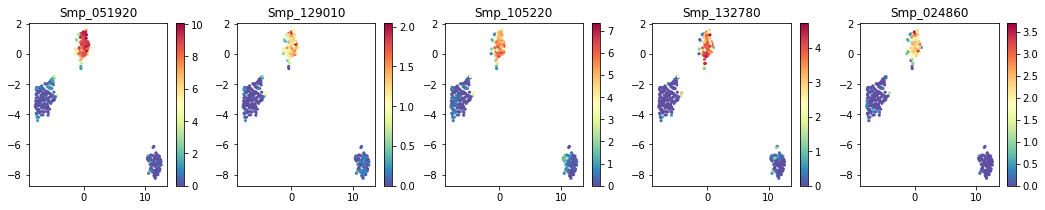

In [15]:
"""Rank genes by their spatially averaged expression pattern correlations to
a desired gene.

Parameters
----------

sam - SAM
    The analyzed SAM object

input_gene - string
    The gene ID with respect to which correlations will be computed.

Returns
-------
A ranked list of gene IDs based on correlation to the input gene.
"""
genes = ut.find_corr_genes(sam,'Smp_051920')
print(genes[:20])

fig,axs = plt.subplots(1,5)
fig.set_size_inches((18,3))
for i in range(5):
    sam.show_gene_expression(genes[i],axes=axs[i], cmap = 'Spectral_r')